In [1]:
import numpy as np
import pandas as pd
import os
import glob

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from matplotlib.collections import PatchCollection
from matplotlib.patches import Polygon

In [3]:
from skimage.draw import ellipse
from skimage.measure import find_contours, approximate_polygon, subdivide_polygon
from skimage import io, color
from skimage import measure
from skimage import transform

In [4]:
from PIL import Image
from numpy import*

In [5]:
import pyproj    
import shapely
import shapely.ops as ops
from shapely.geometry.polygon import Polygon
from functools import partial
from descartes import PolygonPatch

In [6]:
def PolyArea(x,y):
    return 0.5*np.abs(np.dot(x,np.roll(y,1))-np.dot(y,np.roll(x,1)))

In [7]:
def centroid(lstP):
    sumCx = 0
    sumCy = 0
    sumAc= 0
    for i in range(len(lstP)-1):
        cX = (lstP[i][0]+lstP[i+1][0])*(lstP[i][0]*lstP[i+1][1]-lstP[i+1][0]*lstP[i][1])
        cY = (lstP[i][1]+lstP[i+1][1])*(lstP[i][0]*lstP[i+1][1]-lstP[i+1][0]*lstP[i][1])
        pA = (lstP[i][0]*lstP[i+1][1])-(lstP[i+1][0]*lstP[i][1])
        sumCx+=cX
        sumCy+=cY
        sumAc+=pA
    ar = sumAc/2.0
    centr = ((1.0/(6.0*ar))*sumCx,(1.0/(6.0*ar))*sumCy)
    return centr

In [8]:
def get_num_pixels(filepath):
    with Image.open(filepath) as img:
        width, height = img.size
    return width,height

In [9]:
df = pd.DataFrame(columns=["ablated_area", "tetragon","pentagon","hexagon","heptagon","octagon"], 
                      index=[5,10,20,30,40,50,60,70,80,90])

90 :  6 108 5160 472 1
5 :  1 0 0 7 2
10 :  0 0 19 32 7
50 :  0 2 1222 509 7
20 :  1 2 146 104 4
30 :  0 6 362 224 8
60 :  1 5 1877 632 9
40 :  0 2 682 405 9
80 :  2 26 3906 601 4
70 :  4 22 2778 640 9


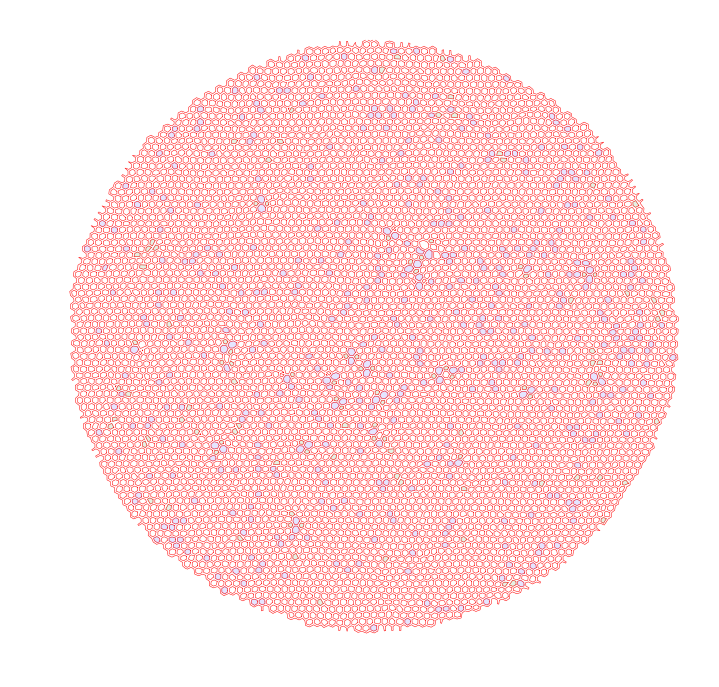

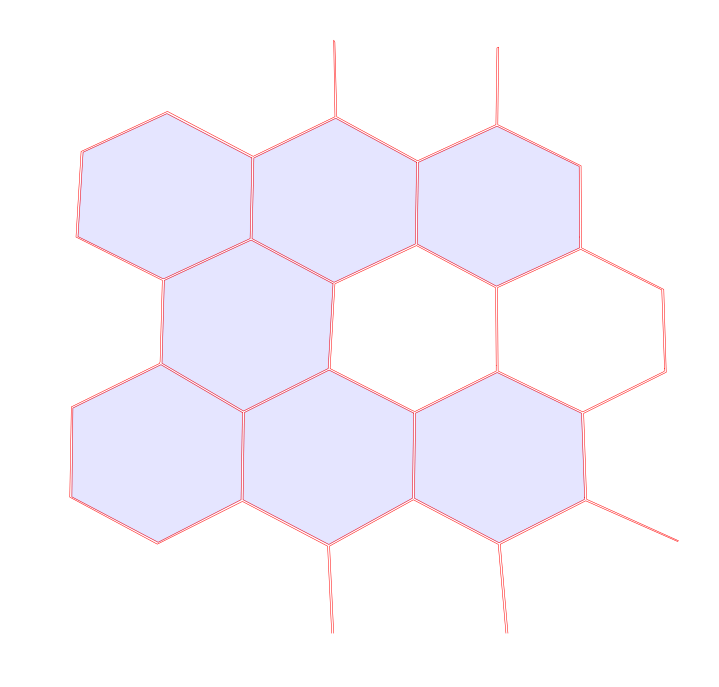

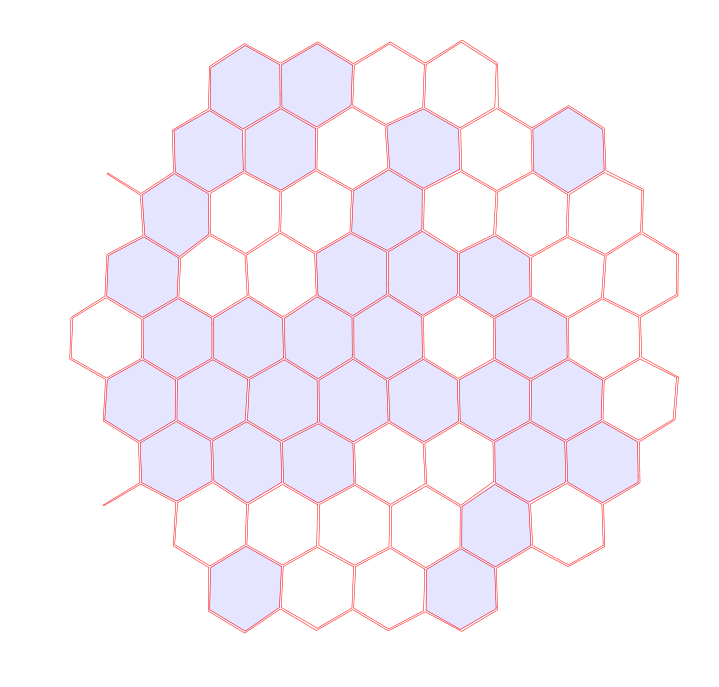

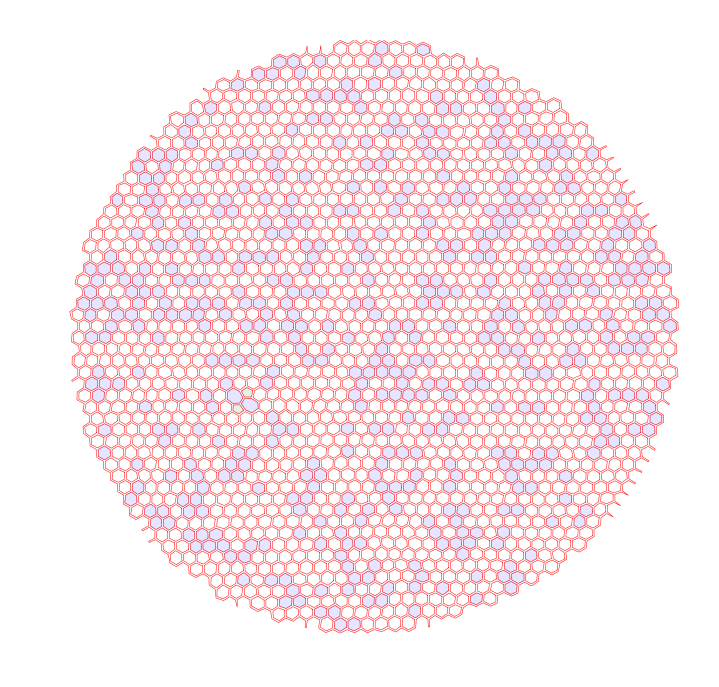

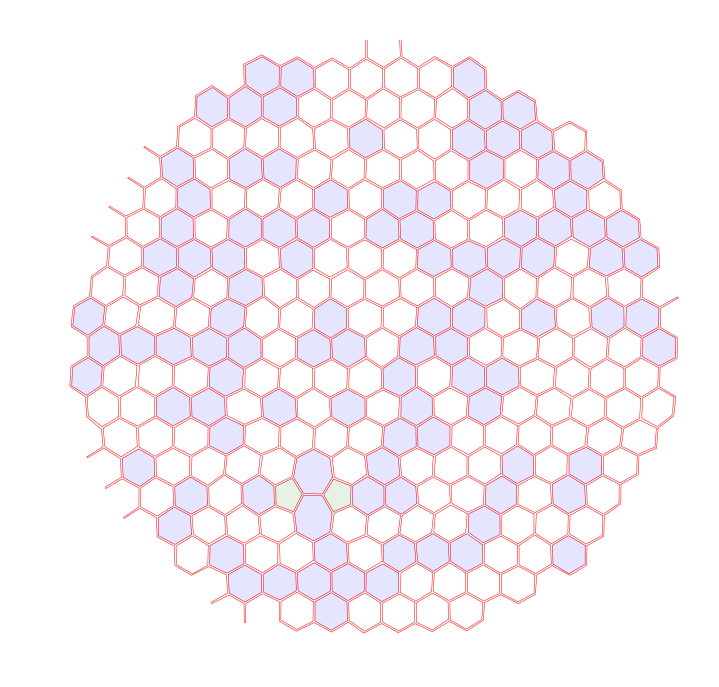

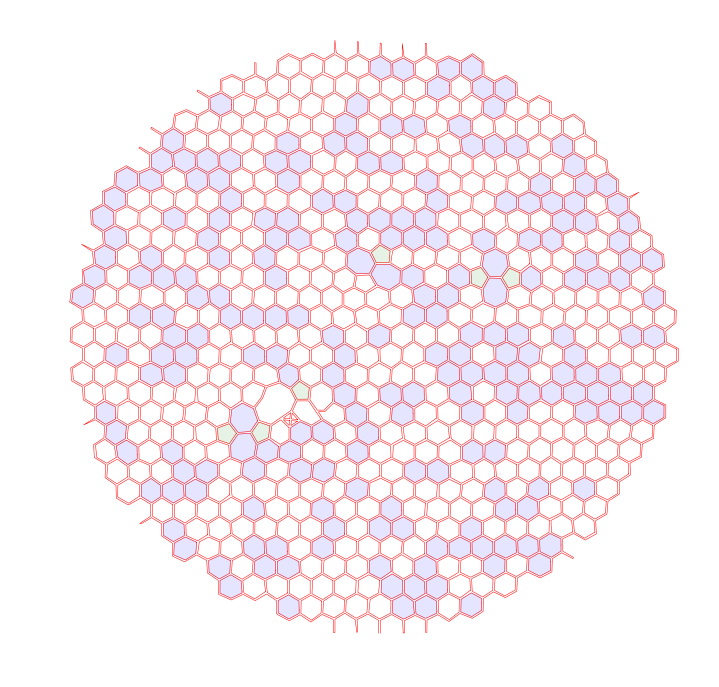

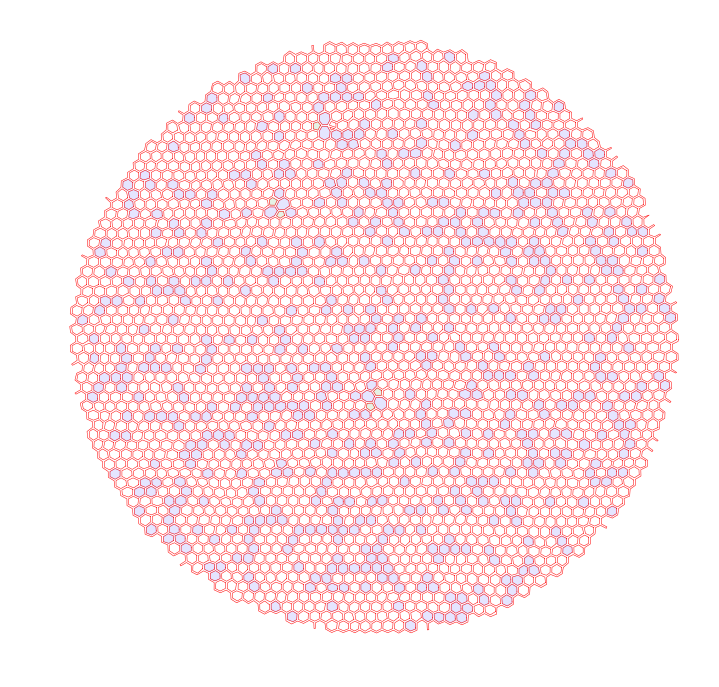

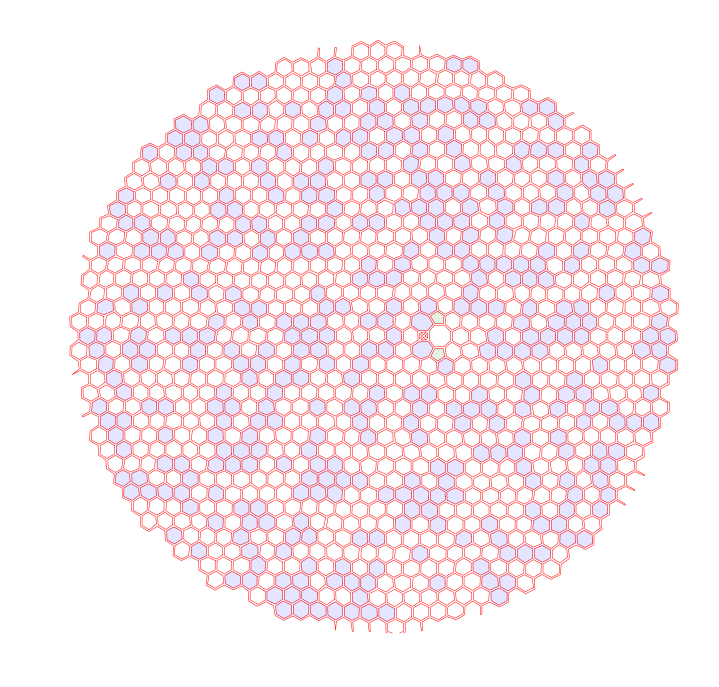

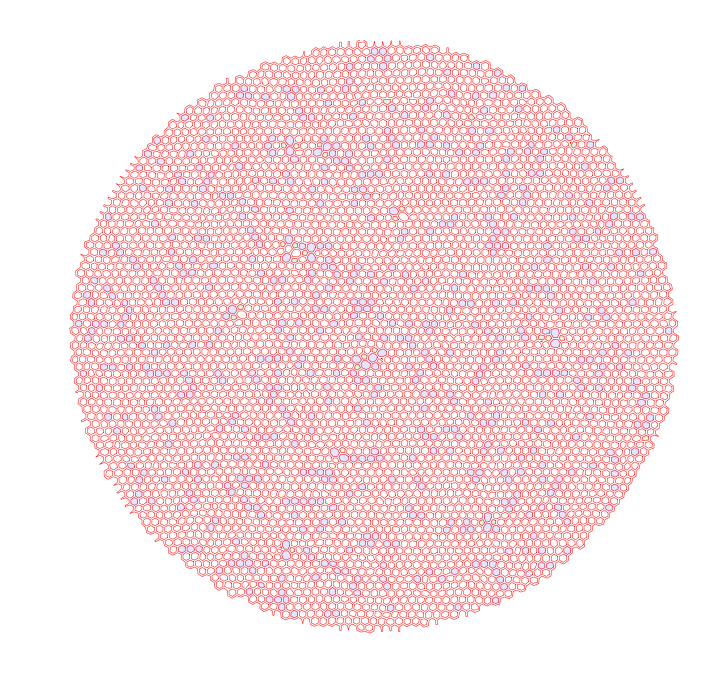

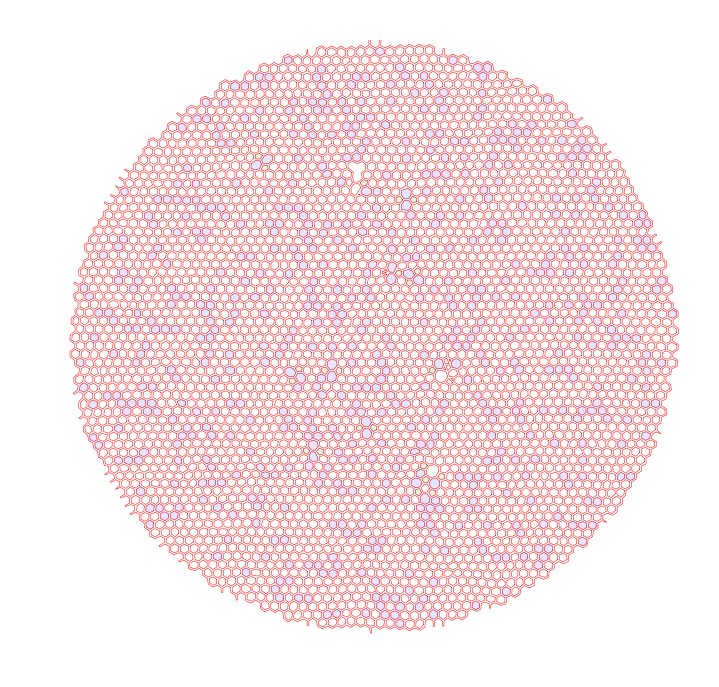

In [10]:
for filename in glob.glob(os.path.join('fig', '*.png')):
#     print(get_num_pixels(filename))
    name = os.path.splitext(filename)[0].split('/')[-1].split('_')[1].split('r')[1] 

    img_color = io.imread(filename)
    img = color.rgb2gray(img_color)

    # Find contours at a constant value of 0.8
    contours = measure.find_contours(img, 20.0,fully_connected='low')

    # Display the image and plot all contours found
    fig, ax = plt.subplots(figsize=(12, 12))
    plt.axis('off')


    tetragon = 0
    pentagon = 0
    hexagon = 0
    heptagon = 0
    octagon = 0
    larea = []
    
    for n, contour in enumerate(contours):
        coords = approximate_polygon(contour, tolerance=10.0)
        if len(coords)-1 == 4:
            tetragon += 1
        if len(coords)-1 == 5:
            pentagon += 1
            center = centroid(coords)
            point = pd.DataFrame({'x': [center[0]], 'y': [center[1]]})
#             ax = point.plot(x='x', y='y', ax=ax,  style='bx')
#             ax.get_legend().remove()
            polygon = Polygon(coords)
            ring_patch = PolygonPatch(polygon, color='g',alpha=0.1)
            ax.add_patch(ring_patch)
        if len(coords)-1 == 6:
            hexagon += 1
        if len(coords)-1 == 7:
            heptagon += 1
            polygon = Polygon(coords)
            ring_patch = PolygonPatch(polygon, color='b',alpha=0.1)
            ax.add_patch(ring_patch)
        if len(coords)-1 == 8:
            octagon += 1
        if len(coords)-1 > 8 :
            larea.append([len(coords)-1, PolyArea(coords[:, 1],coords[:, 0])])
            
        ax.plot(coords[:, 0], coords[:, 1], '-r', linewidth=0.5)
        
        
    larea = sorted(larea,key=lambda x: (x[0],x[1]))[:-1]    
    area = sum(x[1] for x in larea)

    df.loc[int(name)] = pd.Series({"ablated_area":area,"tetragon":tetragon, "pentagon":pentagon,  
                        "hexagon":hexagon,"heptagon":heptagon,"octagon":octagon})
#     plt.show()
    fname = name + '.pdf'
    fig.savefig(fname, bbox_inches='tight')
    print(name,": ",tetragon,pentagon,hexagon,heptagon,octagon)

In [45]:
df['sum67'] = df['hexagon'] + df['heptagon'] 
df['ratio567'] = df['pentagon']/(df['hexagon']+df['heptagon']) 
df['radius'] = df.index
df

,ablated_area,tetragon,pentagon,hexagon,heptagon,octagon,ratio567,radius,ratio67,sum67
5,0,1,0,0,7,2,0,5,7,7
10,0,0,0,19,32,7,0,10,51,51
20,0,1,2,146,104,4,0.008,20,250,250
30,129868,0,6,362,224,8,0.0102389,30,586,586
40,0,0,2,682,405,9,0.00183993,40,1087,1087
50,0,0,2,1222,509,7,0.0011554,50,1731,1731
60,0,1,5,1877,632,9,0.00199283,60,2509,2509
70,28780.3,4,22,2778,640,9,0.00643651,70,3418,3418
80,0,2,26,3906,601,4,0.0057688,80,4507,4507
90,0,6,108,5160,472,1,0.0191761,90,5632,5632


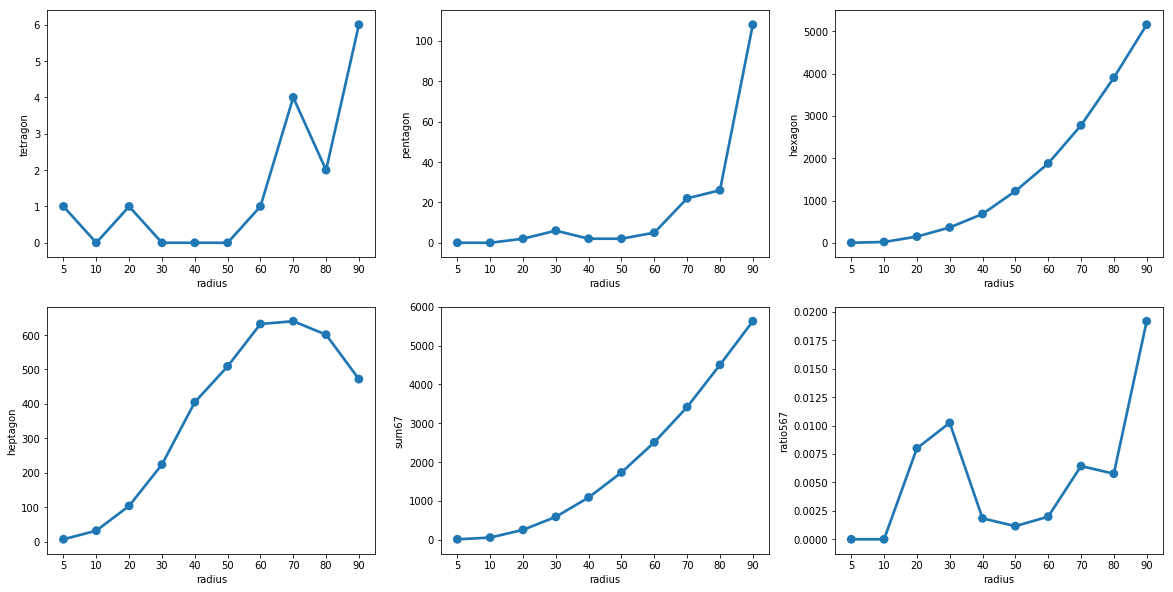

In [46]:
f, axes = plt.subplots(2, 3, figsize=(20, 10), sharex=False)
ax1 = sns.pointplot(x='radius',y='tetragon',data=df, ax=axes[0,0])
ax2 = sns.pointplot(x='radius',y='pentagon',data=df, ax=axes[0,1])
ax3 = sns.pointplot(x='radius',y='hexagon' ,data=df, ax=axes[0,2])
ax4 = sns.pointplot(x='radius',y='heptagon',data=df, ax=axes[1,0])
ax5 = sns.pointplot(x='radius',y='sum67'   ,data=df, ax=axes[1,1])
ax6 = sns.pointplot(x='radius',y='ratio567',data=df, ax=axes[1,2])

# ax1.set(xlabel='',title="molecular weight")
# ax2.set(xlabel='',title="Wildman-Crippen LogP")
# ax3.set(xlabel='',title="topological polar surface area")
# ax4.set(xlabel='',title="number of hydrogen bonds, donor")
# ax5.set(xlabel='',title="number of hydrogen bonds, acceptor")
# ax6.set(xlabel='',title="number of aliphatic carbocycles")

plt.show()
f.savefig("polygon.pdf", bbox_inches='tight')

In [ ]:
img_color = io.imread('fig/70.png')                                             
img = color.rgb2gray(img_color)

print(get_num_pixels('fig/70.png'))


# Find contours at a constant value of 0.8
contours = measure.find_contours(img, 20.0,fully_connected='low')

# Display the image and plot all contours found
fig, ax = plt.subplots(figsize=(12, 12))
plt.axis('off')
# ax.imshow(img, interpolation='nearest', cmap=plt.cm.gray)
# ax.imshow(img_color)

tetragon = 0
pentagon = 0
hexagon = 0
heptagon = 0
octagon = 0
larea = []

for n, contour in enumerate(contours):
    coords = approximate_polygon(contour, tolerance=10.0)
#     patches.append(polygon)
    if len(coords)-1 == 4:
        tetragon += 1
    if len(coords)-1 == 5:
        pentagon += 1
        center = centroid(coords)
        point = pd.DataFrame({'x': [center[0]], 'y': [center[1]]})
#         ax = point.plot(x='x', y='y', ax=ax,  style='bx')
#         ax.get_legend().remove()
        polygon = Polygon(coords)
        ring_patch = PolygonPatch(polygon, color='g',alpha=0.1)
        ax.add_patch(ring_patch)
    if len(coords)-1 == 6:
        hexagon += 1
    if len(coords)-1 == 7:
        heptagon += 1
        polygon = Polygon(coords)
        ring_patch = PolygonPatch(polygon, color='b',alpha=0.1)
        ax.add_patch(ring_patch)
    if len(coords)-1 == 8:
        octagon += 1
    if len(coords)-1 < 8 :
#         ax.add_patch(ring_patch)
        larea.append([len(coords)-1, PolyArea(coords[:, 1],coords[:, 0])])
        ax.plot(coords[:, 0], coords[:, 1], '-r', linewidth=0.5,solid_capstyle='round')


larea = sorted(larea,key=lambda x: (x[0],x[1]))[:-1]
area = sum(n for _, n in larea)
print(area)

plt.show()
fig.savefig("70.pdf", bbox_inches='tight')
print(tetragon,pentagon,hexagon,heptagon,octagon)
print(area)